# Data Augmentation


## Setup Environment

In [1]:
!git init
!git remote add origin https://github.com/sgerloff/sustainable_deepfashion.git
!git pull origin main
#Since we update the code, we need to restore the state at which this notebook was created.
!git checkout 1892e4aaeb52bbff109af82969a60e4b0123845f 

!pip install -r requirements.txt

!make setup-preprocessed-gc CATEGORY_ID=1 MIN_PAIR_COUNT=20

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/sgerloff/sustainable_deepfashion
 * branch            main       -> FETCH_HEAD
Already up to date.
M	src/metrics/triplet_metrics.py
HEAD is now at 1892e4a updated readability of list comprehension
python -m src.google_colab_utility connect_gdrive
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
unzip /gdrive/MyDrive/deepfashion_gc_save/preprocessed_cat_1.zip
Archive:  /gdrive/MyDrive/deepfashion_gc_save/preprocessed_cat_1.zip
replace data/processed/train/cat1/042979_3393.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Visualize Current Batches

In [2]:
from src.data.triplet_batch_generator import TripletBatchGenerator
from src.utility import get_project_dir
import joblib, os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
train_df = joblib.load(os.path.join(get_project_dir(),
                                    "data",
                                    "processed",
                                    "category_id_1_deepfashion_train.joblib"))

validation_df = joblib.load(os.path.join(get_project_dir(),
                                    "data",
                                    "processed",
                                    "category_id_1_deepfashion_validation.joblib"))

batch_gen = TripletBatchGenerator(train_df, 224)

In [4]:
def visualize_batch(dataset, batch_size=16):
  width = int(np.sqrt(batch_size))
  if width**2 != batch_size:
    print(f"Incompatible batch_size: {16}! Expected batch_size=n**2")
  else:
    fig, axs = plt.subplots(width, width, figsize=(batch_size,batch_size))
    for X, y in dataset.take(1):
      for i in range(batch_size):
        idx = i%width
        idy = int(np.floor(i/width))
        axs[idx,idy].imshow(tf.cast(X[i]/255., float))
        axs[idx,idy].axis("off")
        axs[idx,idy].set_title(f"Pair_id: {int(y[i])}")

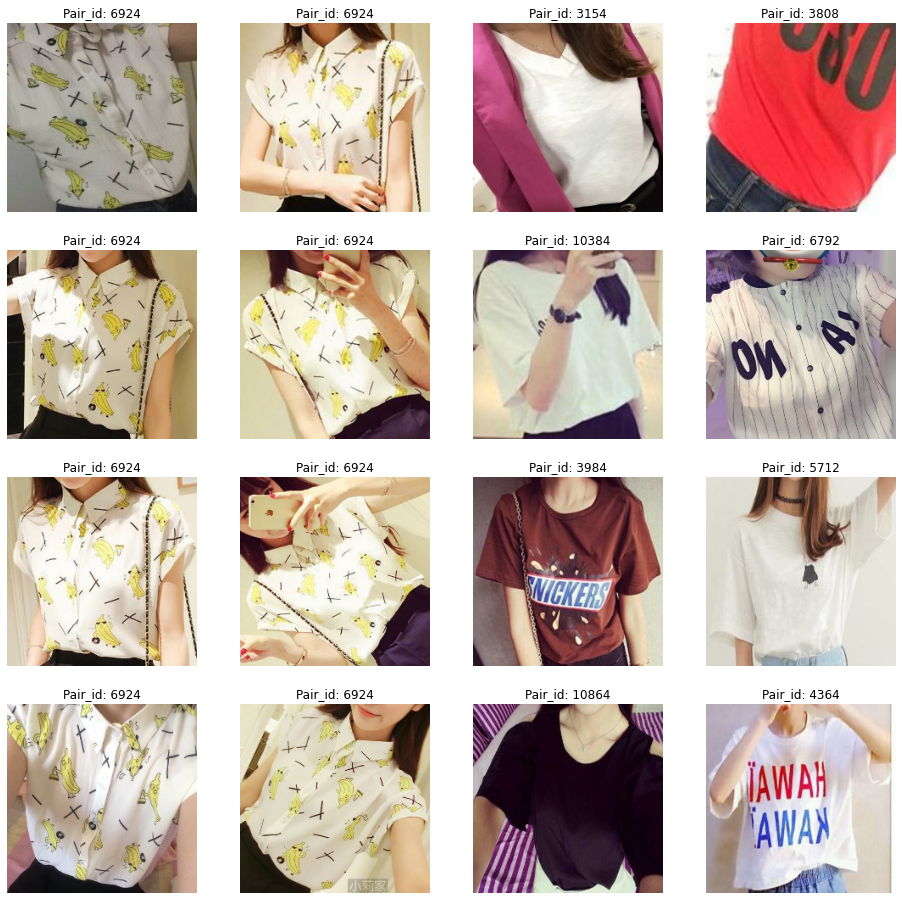

In [5]:
dataset, _ = batch_gen.get_keras_dataset(batch_size=16)
visualize_batch(dataset, batch_size=16)

## Baseline Computation Time

Lets check how long a current epoch usually takes. We compare to this time after implementing augmentation, to monitor the speed loss.

In [6]:
from src.models.efficient_net_triplet import EfficientNetTriplet

In [7]:
effnet = EfficientNetTriplet()
effnet.train(train_df, validation_df, epochs=1, training_ratio=1.0)

912/912 [==============================] - 432s 463ms/step - loss: 0.9405 - score: 0.0000e+00 - val_loss: 0.9022 - val_score: 0.0000e+00


I record about 6mins with 396ms per step. These values obviously fluctuate.

## Add Augmentation to BatchGenerator

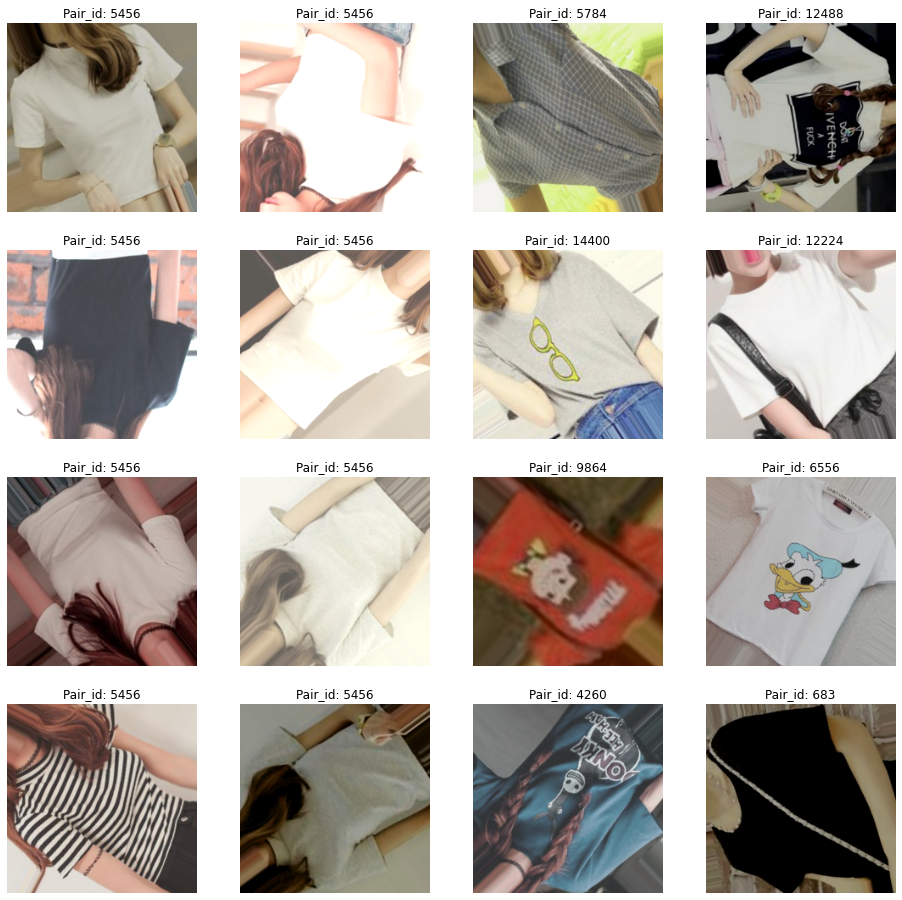

In [8]:
class AugmentedTripletBatchGenerator(TripletBatchGenerator):
  def __init__(self, database, resolution):
    super().__init__(database, resolution)
    self.randomRotiation = tf.keras.layers.experimental.preprocessing.RandomRotation(0.5, fill_mode="nearest")

  def get_array_for_item(self, i):
    x = super().get_array_for_item(i)
    return self.augment(x)

  def augment(self, x):
    tmp_shape = x.shape
    x = self.randomRotiation(tf.expand_dims(x, axis=0))
    x = tf.reshape(x, tmp_shape)

    x = tf.image.random_brightness(x, 64)
    x = tf.image.random_contrast(x, 0.7, 1.)
    x = tf.image.random_hue(x, 0.05)
    x = tf.image.random_saturation(x, 0.6, 1.0)
    x = tf.clip_by_value(x, 0., 255.)
    return x

aug_batch_gen = AugmentedTripletBatchGenerator(train_df, 224)
aug_dataset, _ = aug_batch_gen.get_keras_dataset(batch_size=16)
visualize_batch(aug_dataset, batch_size=16)

Lets Check the Performance:

In [9]:
class AugmentedEfficientNetTriplet(EfficientNetTriplet):
  def get_dataset(self, dataframe, training_ratio=0.1, batch_size=64):
    triplet_batch = AugmentedTripletBatchGenerator(dataframe, self.input_shape[0])
    return triplet_batch.get_keras_dataset(training_size_ratio=training_ratio, batch_size=batch_size)

augmented_effnet = AugmentedEfficientNetTriplet()
augmented_effnet.train(train_df, validation_df, epochs=1, training_ratio=1.0)

912/912 [==============================] - 871s 949ms/step - loss: 0.9641 - score: 0.0000e+00 - val_loss: 0.9460 - val_score: 0.0000e+00


Ouch ... more then 10mins and about 700ms per step ... thats expensive. Lets try to rework the pipeline.

## Augmentation via map-function

In [10]:
class HandsoffBatchGenerator(TripletBatchGenerator):
  def get_keras_dataset(self, batch_size=64, training_size_ratio=1.):
    training_size = int(training_size_ratio*len(self.df["pair_id"].unique()))
    dataset = tf.data.Dataset.from_generator(self.tf_generator, args=[batch_size, training_size],
                                              output_types=(tf.float16, tf.float16),
                                              output_shapes=([self.resolution, self.resolution, 3], ())
                                              )
    return dataset, training_size

In [11]:
class MappedEfficientNetTriplet(EfficientNetTriplet):
  def __init__(self, input_shape=(224, 224, 3)):
    super().__init__(input_shape)
    self.randomRotiation = tf.keras.layers.experimental.preprocessing.RandomRotation(0.5, fill_mode="nearest")

  def get_dataset(self, dataframe, training_ratio=0.1, batch_size=64):
    triplet_batch = HandsoffBatchGenerator(dataframe, self.input_shape[0])
    dataset, training_size = triplet_batch.get_keras_dataset(training_size_ratio=training_ratio, batch_size=batch_size)
    dataset = dataset.map(
        lambda X, y: (self.augment(X), y), num_parallel_calls=-1
        )
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(1).repeat()
    return dataset, training_size

  def augment(self, x):
    tmp_shape = x.shape
    x = self.randomRotiation(tf.expand_dims(x, axis=0))
    x = tf.reshape(x, tmp_shape)

    x = tf.image.random_brightness(x, 64)
    x = tf.image.random_contrast(x, 0.7, 1.)
    x = tf.image.random_hue(x, 0.05)
    x = tf.image.random_saturation(x, 0.6, 1.0)
    x = tf.clip_by_value(x, 0., 255.)
    return x

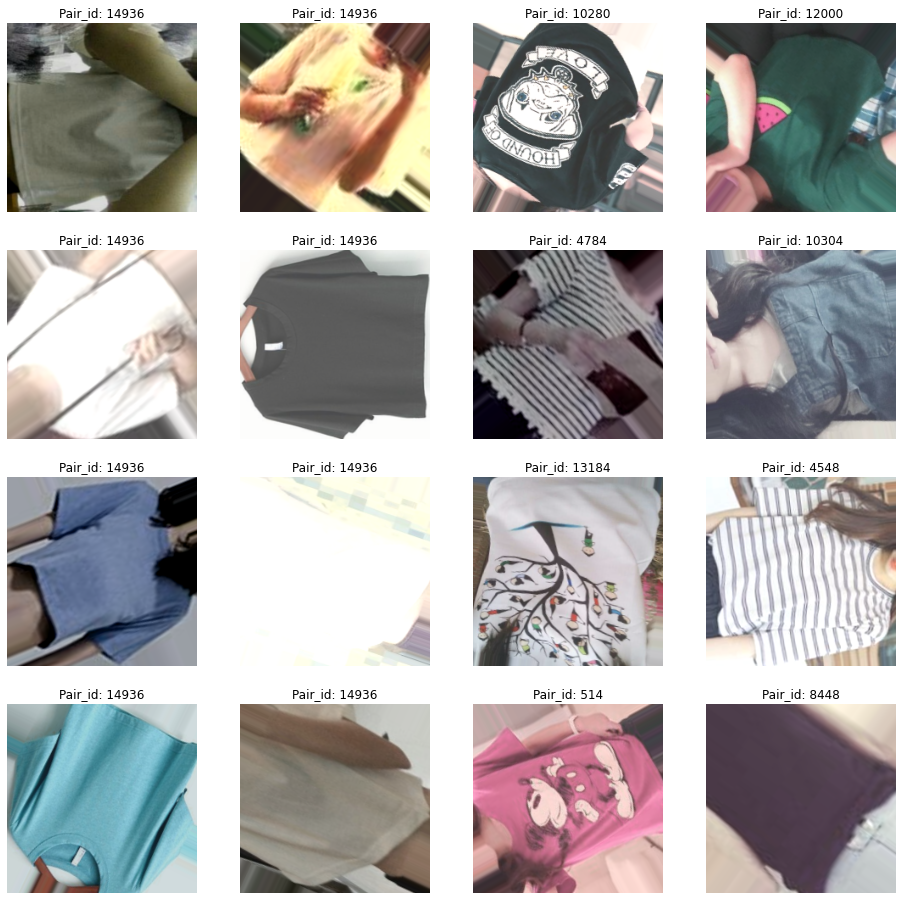

In [12]:
mapped_effnet = MappedEfficientNetTriplet()
map_dataset, _ = mapped_effnet.get_dataset(train_df, training_ratio=1.0, batch_size=16)
visualize_batch(map_dataset, batch_size=16)

And again, the performance:

In [13]:
mapped_effnet = MappedEfficientNetTriplet()
mapped_effnet.train(train_df, validation_df, epochs=1, training_ratio=1.0)

912/912 [==============================] - 609s 662ms/step - loss: 0.9629 - score: 0.0000e+00 - val_loss: 0.9489 - val_score: 0.0000e+00


Okay ... thats slightly faster. A little less then 10mins, with 610ms per step. This is on only 2 CPU's, thus on AWS or similar, we might be even faster.

# One Step Further

The map function worked really well, and I am generally unsatisfied with the TripletBatchGenerator knowing anything about the resolution and similar stuff. What if we created batches that only contain the paths to the images and create a function inside the model that produces proper batches from that. Could yield a speed up:

In [14]:
class GenericTripletBatchGenerator(HandsoffBatchGenerator):
  def __init__(self, database):
    super().__init__(database, 224)

  def get_array_for_item(self, i):
    path = self.df.loc[i, "image"]
    return path

  def get_keras_dataset(self, batch_size=64, training_size_ratio=1.):
    training_size = int(training_size_ratio*len(self.df["pair_id"].unique()))
    dataset = tf.data.Dataset.from_generator(self.tf_generator, args=[batch_size, training_size],
                                              output_types=(tf.string, tf.float16),
                                              # output_shapes=((), ())
                                              )
    return dataset, training_size

In [15]:
class EmancipatedEfficientNetTriplet(EfficientNetTriplet):
  def __init__(self, input_shape=(224, 224, 3)):
    super().__init__(input_shape)
    self.randomRotiation = tf.keras.layers.experimental.preprocessing.RandomRotation(0.5, fill_mode="nearest")

  def get_dataset(self, dataframe, training_ratio=0.1, batch_size=64):
    triplet_batch = GenericTripletBatchGenerator(dataframe)
    dataset, training_size = triplet_batch.get_keras_dataset(training_size_ratio=training_ratio, batch_size=batch_size)
    dataset = dataset.map( self.preprocess, num_parallel_calls=-1)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(1).repeat()
    return dataset, training_size

  def preprocess(self, x, y):
    x = tf.io.read_file(x)
    x = tf.io.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [self.input_shape[0], self.input_shape[1]])
    x = self.augment(x)
    return x, tf.reshape(y, ())

  def augment(self, x):
    tmp_shape = x.shape
    x = self.randomRotiation(tf.expand_dims(x, axis=0))
    x = tf.reshape(x, tmp_shape)

    x = tf.image.random_brightness(x, 64)
    x = tf.image.random_contrast(x, 0.7, 1.)
    x = tf.image.random_hue(x, 0.05)
    x = tf.image.random_saturation(x, 0.6, 1.0)
    x = tf.clip_by_value(x, 0., 255.)
    x = tf.cast(x, tf.float16)
    return x

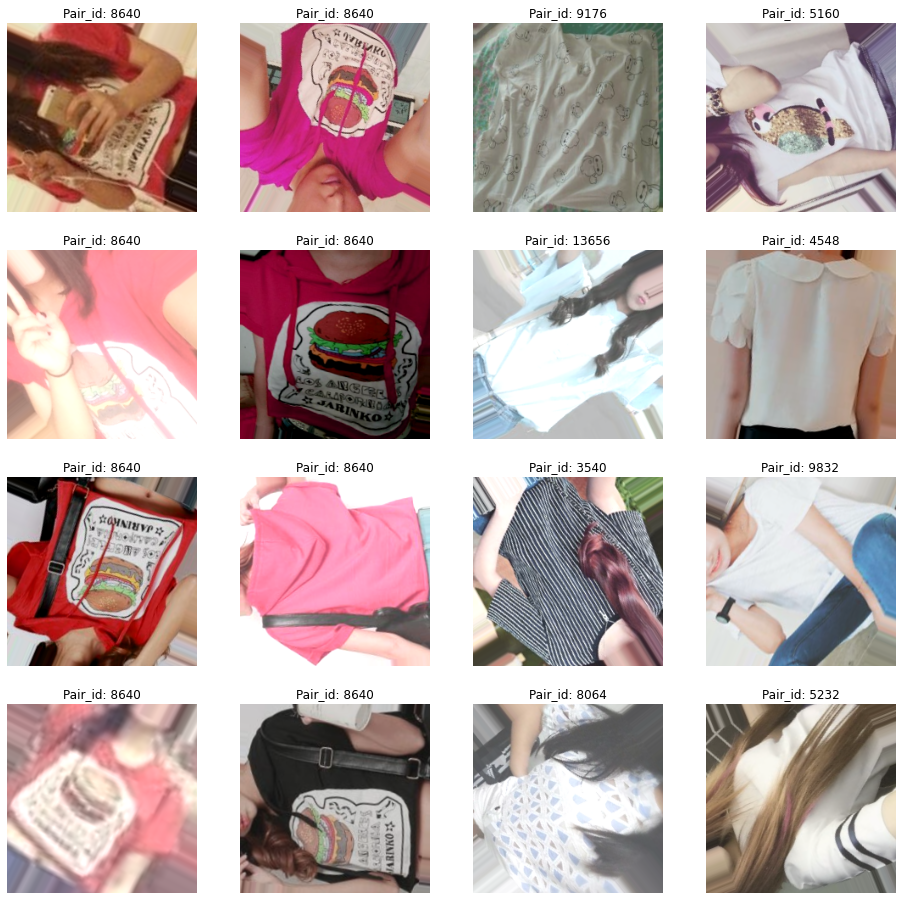

In [16]:
emancipated_effnet = EmancipatedEfficientNetTriplet()
emancipated_dataset, _ = emancipated_effnet.get_dataset(train_df, training_ratio=1.0, batch_size=16)
visualize_batch(emancipated_dataset, batch_size=16)

In [17]:
emancipated_effnet = EmancipatedEfficientNetTriplet()
emancipated_effnet.train(train_df, validation_df, epochs=1, training_ratio=1.0)

912/912 [==============================] - 485s 526ms/step - loss: 0.9635 - score: 0.0000e+00 - val_loss: 0.9478 - val_score: 0.0000e+00


The speedup seems somewhat minor ... still its probably worth to implement anyway.